In [6]:
import os   #These two are useful modules
import sys

#here you can import other useful modules, such as numpy, matplotlib, etc..
import numpy as np #Numerical Python
import matplotlib.pyplot as plt

#also import astropy.fits
from astropy.io import fits

#import package to caclulate remaining loop time
import time
from time import sleep
from tqdm import tqdm
from tqdm.notebook import tqdm

In [7]:
# Let's define te directory where you are with the "get current working directory" command...
work_dir = os.getcwd()
print("I am in dir %s" % work_dir)

#We can go up by using the path.dirname
main_dir =os.path.dirname(work_dir)
print("Main directory is %s" % main_dir)

#We can then define the data directory using the os.path.join command
data_dir = os.path.join(main_dir,"data")
print("Data directory is %s" % data_dir)

#..and we can define some output directory with the results
results_dir = os.path.join(main_dir,"results")

#if the directory does not exist, you can create it...
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    print("Directory %s created!" % results_dir)
else:
    print("Results directory is %s" % results_dir)

I am in dir /home/sara/Scrivania/1magistrale/multimessenger/GW/experience-gw-Sara-a-r/code
Main directory is /home/sara/Scrivania/1magistrale/multimessenger/GW/experience-gw-Sara-a-r
Data directory is /home/sara/Scrivania/1magistrale/multimessenger/GW/experience-gw-Sara-a-r/data
Results directory is /home/sara/Scrivania/1magistrale/multimessenger/GW/experience-gw-Sara-a-r/results


In [8]:
#Let's see the data relative to the detection that I have choose (GW150914)
#you will receive a list of files, that you could download in your data dir for future use,
#or just use the fetch command (see below) to use the files in real time 
ev_name = "GW150914"

#interferometer to use
ev_ifo = "L1"


from gwosc.datasets import event_gps
from gwosc.locate import get_event_urls

ev_gps = event_gps(ev_name)
event_urls = get_event_urls(ev_name)

print("Ev name: %s,\nEv_gps: %.1f,\nEv_urls: %s\n" % (ev_name,ev_gps,event_urls))

Ev name: GW150914,
Ev_gps: 1126259462.4,
Ev_urls: ['https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5', 'https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5']



In [9]:
#Here we will select a time frame and see how we can have a quick look at the signal and do some basic filtering

from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag

# Select a time interval of 10 s around the event. This is because on GWOSC there is 1 hour data window released around events
dt_win=10
ev_t0_min = ev_gps-dt_win
ev_t0_max = ev_gps+dt_win

print("Get data for %s (%s) GPS: %.2f - %.2f" % (ev_name,ev_ifo,ev_t0_min,ev_t0_max))

#fetch the data. Use cache=True to keep the data in the cache memory (to speed things up)
data = TimeSeries.fetch_open_data(ev_ifo,ev_t0_min,ev_t0_max,cache=True)
print('------------------------------------------------------------')
print(data)

#get the segments in a larger time window (just to have a bigger time span to look over)
segments = DataQualityFlag.fetch_open_data(ev_ifo+"_DATA",ev_t0_min-dt_win,ev_t0_max+dt_win)
print('Done L')


Get data for GW150914 (L1) GPS: 1126259452.40 - 1126259472.40
------------------------------------------------------------
TimeSeries([-1.11661830e-18, -1.10578056e-18, -1.06578088e-18,
            ..., -5.43098222e-19, -5.14140699e-19,
            -5.49796980e-19]
           unit: dimensionless,
           t0: 1126259452.3999023 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)
Done L


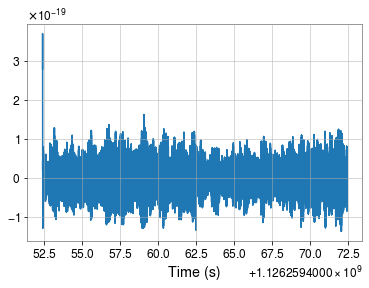

In [10]:
import pylab
from pycbc.filter import resample_to_delta_t, highpass

#-----------------------------------------HANFORD-----------------------------------------------

# Convert the data from gwpy to pyCBC format
strain = data.to_pycbc()

# Remove the frequencies below 15 Hz and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

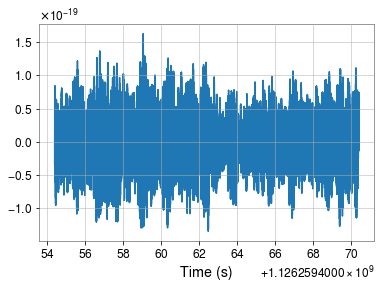

In [11]:
# Remove 2 seconds of data from both the beginning and end, to remove the ringing artifacts
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()


In [12]:
#We can calculate the ASD and PSD also with pyCBC

from pycbc.psd import interpolate, inverse_spectrum_truncation

# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

### Find masses

In [13]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
import numpy


#we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume non-rotating black holes which is within the posterior probabilityof GW150914. 
m_guess = 30 # Solar masses
step = 10  #from 20 to 40 
dm = 0.25

m1 = np.arange(m_guess-step,m_guess+step, dm)
m2 = np.arange(m_guess-step,m_guess+step, dm)

snrp = np.zeros((len(m1),len(m2)))
time_p = np.zeros((len(m1),len(m2)))

start = time.time()
for i in tqdm(range (0,len(m1))):
    for j in range (0,len(m2)):
        hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1[i],
                     mass2=m2[j],
                     delta_t=conditioned.delta_t,
                     f_lower=20)
        hp.resize(len(conditioned))  # We will resize the vector to match our data
        # The waveform begins at the start of the vector, so if we want the
        # SNR time series to correspond to the approximate merger location
        # we need to shift the data so that the merger is approximately at the 
        # first bin of the data.

        # The cyclic_time_shift method shifts the timeseries by a given amount of time.
        # It treats the data as if it were on a ring so points shifted off the end
        # of the series reappear at the start. Note that time stamps are *not* in
        # general affected (as the start time of the full array is shifted),
        # but the index of each point in the vector is.

        # By convention waveforms returned from `get_td_waveform` have their
        # merger stamped with time zero, so we can use the start time to 
        # shift the merger into position
        template = hp.cyclic_time_shift(hp.start_time)
        snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
        # Remove time corrupted by the template filter and the psd filter
        # We remove 4 seonds at the beginning and end for the PSD filtering
        # And we remove 4 additional seconds at the beginning to account for
        # the template length (this is somewhat generous for 
        # so short a template). A longer signal such as from a BNS, would 
        # require much more padding at the beginning of the vector.
        snr = snr.crop(4 + 4, 4)
        # Why are we taking an abs() here?
        # The `matched_filter` function actually returns a 'complex' SNR.
        # What that means is that the real portion correponds to the SNR
        # associated with directly filtering the template with the data.
        # The imaginary portion corresponds to filtering with a template that
        # is 90 degrees out of phase. Since the phase of a signal may be 
        # anything, we choose to maximize over the phase of the signal.
        peak = abs(snr).numpy().argmax()
        snrp[i][j] = snr[peak]
        time_p[i][j] = snr.sample_times[peak]

<ipython-input-13-376722144071>:61: ComplexWarning: Casting complex values to real discards the imaginary part
  snrp[i][j] = snr[peak]


In [24]:
#find m1 and m2 that give the maximum of snr
snrp = abs(snrp) 
Max_snrp = snrp.max()
index = np.where(snrp == Max_snrp)
time_max = time_p[67][50]
m1_max = m1[index[0]]
m2_max = m2[index[1]]

print('(M1, M2) = (%f, %f)' % (m1_max, m2_max))
print('SNR max is %f' % (Max_snrp))
print('Time : %f' % (time_max))

#print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

(M1, M2) = (36.750000, 32.500000)
SNR max is 13.306489
Time : 1126259462.418457


### Wave form Livingston

Text(0, 0.5, 'Strain')

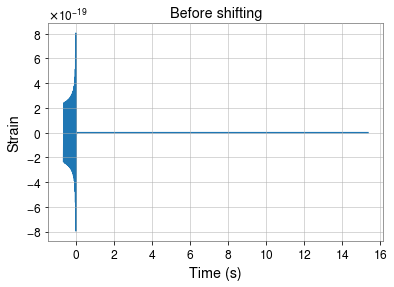

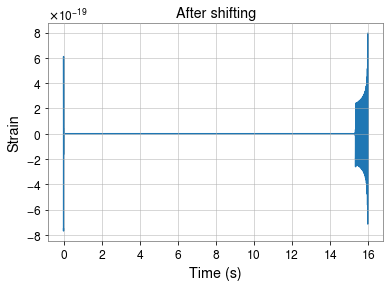

In [25]:
from pycbc.waveform import get_td_waveform
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, and non-rotating black holes which is within the posterior probability
# of GW150914. 

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=32.50,
                     mass2=36.75,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# The cyclic_time_shift method shifts the timeseries by a given amount of time.
# It treats the data as if it were on a ring so points shifted off the end
# of the series reappear at the start. Note that time stamps are *not* in
# general affected (as the start time of the full array is shifted),
# but the index of each point in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

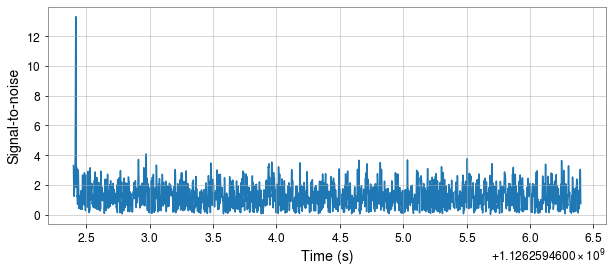

We found a signal at 1126259462.418457s with SNR 13.31566004023484


In [26]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [27]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

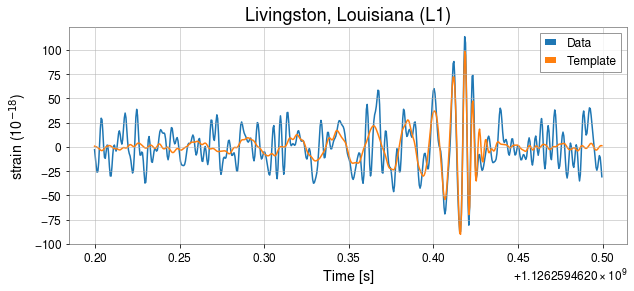

In [40]:
# We do it this way so that we can whiten (i.e. normalize the signal to the PSD) both the template and the data

white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(ev_gps-.2, ev_gps+.1)
white_template = white_template.time_slice(ev_gps-.2, ev_gps+.1)

pylab.figure(figsize=[10, 4])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.title('Livingston, Louisiana (L1)', fontsize=18)
pylab.xlabel('Time [s]')
pylab.ylabel('strain (10$^{-18}$)')
pylab.legend()

#save figure in results directory
out_name = os.path.join(results_dir,"templateL.png")
pylab.savefig(out_name, dpi = 200)
pylab.show()

### Q transform

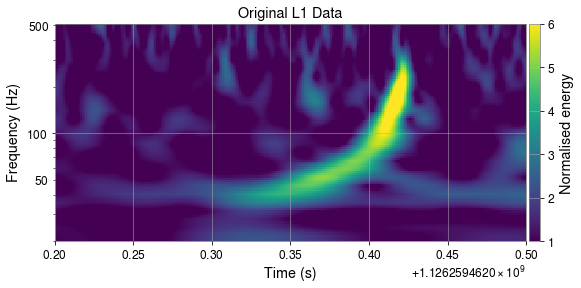

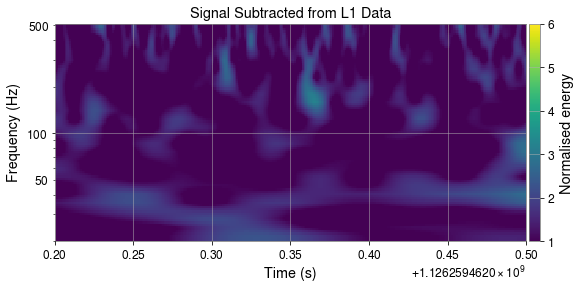

In [44]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original L1 Data'),
                    (subtracted, 'Signal Subtracted from L1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                           logfsteps=100,
                                           qrange=(8, 8),
                                           frange=(20, 512))
    pylab.figure(figsize=[10, 4])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(ev_gps - 0.2, ev_gps + 0.1)
    pylab.colorbar(label="Normalised energy", pad=0.005)
    #save figure in results directory
    if title=='Original L1 Data':
        out_name = os.path.join(results_dir,"qfL.png")
        pylab.savefig(out_name, dpi = 200)
        
    out_name = os.path.join(results_dir,"qf_noSL.png")
    pylab.savefig(out_name, dpi = 200)
    pylab.show()